In [1]:
def loadGraphFromFile(file_name):

        n_nodes = 0
        n_edges = 0
        n_terminals = 0

        edges = []
        terminals = []

        with open(file_name, 'r') as file:

            for line in file:
                word_list = line.split()

                if(len(word_list) == 0):
                    continue

                if(word_list[0] == 'Nodes'):
                    n_nodes = int(word_list[1])

                if(word_list[0] == 'Edges'):
                    n_edges = int(word_list[1])

                if(word_list[0] == 'Terminals'):
                    n_terminals = int(word_list[1])

                if(word_list[0] == 'E'):
                    edges.append([int(word_list[1]) - 1, int(word_list[2]) - 1, int(word_list[3])])

                if(word_list[0] == 'T'):
                    terminals.append(int(word_list[1]) - 1)
                    
        return [n_nodes, n_edges, n_terminals, edges, terminals]

In [2]:
class SteinerTree:
    
    def __init__(self, file_name, opt):
        
        initList = loadGraphFromFile(file_name)
        
        self.name = file_name[-7:-4]
        self.opt = opt
        self.numNodes = initList[0]
        self.numEdges = initList[1]
        self.numTerms = initList[2]
        self.edges = initList[3]
        self.terminals = initList[4]

In [3]:
bGraphList = [
    ('b01.stp', 82),
    ('b02.stp', 83),
    ('b03.stp', 138),
    ('b04.stp', 59),
    ('b05.stp', 61),
    ('b06.stp', 122),
    ('b07.stp', 111),
    ('b08.stp', 104),
    ('b09.stp', 220),
    ('b10.stp', 86),
    ('b11.stp', 88),
    ('b12.stp', 174),
    ('b13.stp', 165),
    ('b14.stp', 235),
    ('b15.stp', 318),
    ('b16.stp', 127),
    ('b17.stp', 131),
    ('b18.stp', 218)
]

In [4]:
import os

bDataPath = os.path.abspath(os.getcwd()) + '\\..\\data\\B'

print(bDataPath)
filenames = os.listdir(bDataPath)
print(filenames)

bGraphs = []

for st_args in bGraphList:
    graphpath = bDataPath + '\\' + st_args[0]
    graphopt = st_args[1]
    bGraphs.append(SteinerTree(graphpath, graphopt))
    
print(len(bGraphs))
print(bGraphs[9].name)

G:\RI\Projekat\RI-Min-Steiner-Tree\code\..\data\B
['b01.stp', 'b02.stp', 'b03.stp', 'b04.stp', 'b05.stp', 'b06.stp', 'b07.stp', 'b08.stp', 'b09.stp', 'b10.stp', 'b11.stp', 'b12.stp', 'b13.stp', 'b14.stp', 'b15.stp', 'b16.stp', 'b17.stp', 'b18.stp']
18
b10


In [5]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
from scipy.sparse.csgraph import reconstruct_path
import math
import numpy as np

In [89]:
def removeOneDegNodes(adj_matrix, terminal_list):
    
    L = np.copy(adj_matrix)
    
    N = len(adj_matrix)
    
    #prati koji cvorovi su ukljuceni u drvo
    selected = np.zeros(N)
    
    i = 0
    
    while i < N:
        
        if(terminal_list[i] != 1 and np.count_nonzero(L[i]) == 1):
            
            for j in range(N):
                
                    L[i][j] = 0
                    L[j][i] = 0
            
            i = 0
        else:
            i = i+1
            
    for i in range(N):
        
        if(terminal_list[i] == 1 or np.count_nonzero(L[i]) != 0):
            selected[i] = 1
            
    return (L, selected)
    

def makeInitialSolution(terminal_list, adj_matrix):
    
    N = len(adj_matrix)
    
    adj_matrix_c = adj_matrix.copy()
    
    X = csr_matrix(adj_matrix_c.tolist())
    
    Tcsr = minimum_spanning_tree(X)
    
    Tcsr = Tcsr.toarray().astype(int)
    
    #pravim matricu simetricnom
    Tcsr = Tcsr + Tcsr.T - np.diag(np.diag(Tcsr))
    
    n_components, labels = connected_components(Tcsr, directed=False, return_labels=True)
    
    #ova funkcija brise grane ka cvorovima koji nisu terminali imaju stepen 1
    new_adj_matrix, selected = removeOneDegNodes(Tcsr, terminal_list)
    
    value = sum(sum(new_adj_matrix)) / 2
    
    print(value)
    
    return (selected, new_adj_matrix, value)

#od liste predecessora pravi putanju
def get_path(Pr, i, j):
    
    path = [j]
    k = j
    
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
        
    return path[::-1]

def pathValue(path, adj_matrix):
    
    N = len(adj_matrix)
    
    value = 0
    
    for e in range(len(path) - 1):
        
        i = path[e]
        j = path[e+1]
        
        value = value + adj_matrix[i][j]
    
    return value

#da li terminali pripadaju istoj komponenti
def termsInSameComp(solution, terminal_list):
    
    n_components, labels = connected_components(solution, directed=False, return_labels=True)
    
    terminal_component_array = []
    for i in range(len(labels)):
        if(terminal_list[i] == 1):
            terminal_component_array.append(labels[i])
                
    if(terminal_component_array.count(terminal_component_array[0]) == len(terminal_component_array)):
        return (True, terminal_component_array)
    else:
        return (False, terminal_component_array)
    
        
def makeNeighbourSolution(solution, terminal_list, adj_matrix):
    
    current_solution = np.copy(solution)
    
    n_components, labels = connected_components(current_solution, directed=False, return_labels=True)
    
    #brisemo random granu
    (i, j) = np.nonzero(current_solution)
    num_pairs = len(i)
    
    random_edge = np.random.randint(num_pairs)
    
    current_solution[i[random_edge]][j[random_edge]] = 0
    current_solution[j[random_edge]][i[random_edge]] = 0
    
    #odredjujemo komponente povezanosti
    X = csr_matrix(current_solution.tolist())
    
    n_components, labels = connected_components(X, directed=False, return_labels=True)
    
    #trazimo minimalni put izmedju dve komponente povezanosti
    min_path = []
    min_path_value = 10000 #nesto mnogo
    
    #izdvajamo oznake komponenti povezanosti kojim pripadaju nasi terminali
    label1 = 0
    label2 = 0
    
    for i in range(len(terminal_list)):
        if(terminal_list[i] == 1):
            label1 = labels[i]
            break
            
    for i in range(len(terminal_list)):
        if(terminal_list[i] == 1 and labels[i] != label1):
            label2 = labels[i]
            break
    
    for i in range(len(labels)):
        
        if(labels[i] == label1):
            
            for j in range(len(labels)):
                
                if(labels[j] == label2):
                    
                    graph = csr_matrix(adj_matrix)
                    
                    dist, pred = shortest_path(graph, directed=False, method='FW', return_predecessors=True)
                    
                    path = get_path(pred, i, j)
                    
                    path_value = pathValue(path, adj_matrix)
                    
                    if(path_value < min_path_value):
                        min_path_value = path_value
                        min_path = path.copy()
                    
    new_solution = np.copy(current_solution)
    
    path_len = len(min_path)
    
    for i in range(path_len-1):
        
        row = min_path[i]
        col = min_path[i+1]
        
        #print("Dodajemo")
        new_solution[row][col] = adj_matrix[row][col]
        new_solution[col][col] = adj_matrix[col][row]
    
    new_solution, new_selected = removeOneDegNodes(new_solution, terminal_list)
            
    #####################   
    new_value = sum(sum(new_solution.astype(int)))
    
    return (new_selected, new_solution, new_value)

def simulatedAnnealing(st: SteinerTree):
    
    N = st.numNodes
    edge_number = st.numEdges
    term_number = st.numTerms
    optimal = st.opt
    edges = st.edges
    terminals = st.terminals
    
    terminal_list = np.zeros(N)
    
    for t in terminals:
        terminal_list[t] = 1
    
    adj_matrix = np.zeros((N, N))
    
    for e in edges:
        adj_matrix[e[0]][e[1]] = e[2]
        adj_matrix[e[1]][e[0]] = e[2]
    
    total_value = np.sum(adj_matrix) / 2
    
    MAX_ITER = 10000
    
    #napraviti moguce resenje problema praveci mcst i brisanjem svih cvorova stepena jedan
    #resenje predstavlje matricu povezanosti stainerovog stabla
    best_selected, best_solution, best_value = makeInitialSolution(terminal_list, adj_matrix)
    
    iteration = 1
    
    func_eval_GA = 0
    fit_GA = []
    
    while iteration < MAX_ITER:
        
        #napraviti novo resenje iz okoline proslog brisanjem random grane
        #i ponovnim povezivanjem minimalnim putem
        current_selected, current_solution, current_value = makeNeighbourSolution(best_solution, terminal_list, adj_matrix)
        
        check, tca = termsInSameComp(current_solution, terminal_list)
        
        while(not check):
            current_selected, current_solution, current_value = makeNeighbourSolution(best_solution, terminal_list, adj_matrix)
            check, tca = termsInSameComp(current_solution, terminal_list)
        
        #provera vrednosti resenja i potencijalna zamena
        if(current_value < best_value):
            
            best_value = current_value
            best_solution = np.copy(current_solution)
            best_selected = np.copy(best_selected)
            
        else:
            
            T = MAX_ITER - iteration
            
            delta = current_value - best_value
            
            p = math.exp(- delta / T)
            
            q = np.random.rand()
            
            if p > q:
                best_value = current_value
                best_solution = np.copy(current_solution)
                best_selected = np.copy(best_selected)
                
        iteration = iteration + 1
        func_eval_GA = func_eval_GA + 1
        
        if best_value > total_value:
            fit_GA.append(total_value)
        else:
            fit_GA.append(best_value)
            
        if(iteration % 1000 == 0):
            print("=");
            
        if best_value == optimal:
            break
        
    return (func_eval_GA, fit_GA, best_value)

In [93]:
func_eval_GA, fit_GA, best_value = simulatedAnnealing(bGraphs[0])

83.0
=
=
=
=
=
=
=
=
=
=


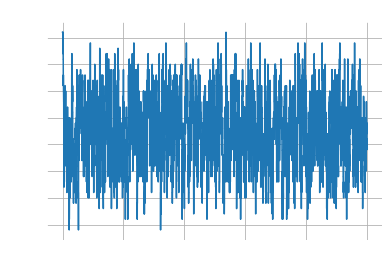

In [94]:
import matplotlib.pyplot as plt

x = np.arange(0, func_eval_GA, 1)
y = fit_GA

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='SA iterations', ylabel='Steiner Tree value',
       title='Simulated Annealing algorithm to b01 dataset')
ax.grid()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

plt.show()

In [95]:
print(best_value)
print(func_eval_GA)

146
9999
